In [1]:
import sqlite3
import pandas as pd
from retentioneering.eventstream import Eventstream
connect = sqlite3.connect('lessons.sqlite')

# Задание
Мы хотим снизить стоимость одного из наших продуктов с 400 у.е. до 160 у.е. Необходимо:
[ ] Задизайнить эксперимент. В качестве ключевой метрики – взять конверсию в платящего;
[ ] Датасет можно исследовать на всех данных, а дизайнить АБ на контрольной группе;
[ ] Проанализировать результаты;
[ ] Подготовить мини-презентацию результатов;

# Данные
__actions__ – данные о совершаемых пользователем событиях:
- uid – идентификатор пользователя; 
- ts – время совершения события; 
- action – название события, где `firstOpen` – первое открытие приложения после установки, `function%` – использование какой-либо функции приложения; 

__experiments__ – данные о принодлежности пользователя к группам эксперимента. Один пользователь может быть в нескольких экспериментах одновременно:
- experimetn – название эксперимента;
- group – группа в эксперименте (old = control, new = test);
- uid – идентификатор пользователя; 

__payments__ – данные о покупках пользователей. В сервисе есть два типа покупок (товаров), которые могут быть осуществлены одновременно:
- uid – идентификатор пользователя;
- payment_type – тип покупки;
- payment – платеж, который пришел в сервис;  


# Решение

## Анализ предоставленных данных 

In [46]:
# Выберем только тех пользователей, которые принимали участие в анализируемом нами АБ (paymentChange)
sql = """
with
    users_labels as (
        select
            experiment,
            uid,
            count(distinct(group_label)) as uniq_group_cnt,
            json_group_array(distinct(group_label)) as uniq_group_label
        from ab_experiments
        where experiment == 'paymentChange'
        group by  experiment, uid
    ),

    users_payments as (
        select
            uid,
            json_group_array(payment_type) as arr_payment_type,
            json_group_array(payment) as arr_payment,
            count(distinct payment) as uniq_payment_cnt
        from ab_payments
        group by uid
    ),

    data as (
        select
            a.uid, a.ts, date(a.ts) as date, a.action,
            l.experiment, l.uniq_group_cnt, json_extract(l.uniq_group_label, '$[0]') as uniq_group_label,
            p.arr_payment_type, p.arr_payment,
            case when p.uniq_payment_cnt is null then 0 else p.uniq_payment_cnt end as uniq_payment_cnt,
            case when p.uniq_payment_cnt is null then 0 else 1 end as is_payment_uid
        from ab_actions as a
        left join users_labels as l on a.uid == l.uid
        left join users_payments as p on a.uid == p.uid
        order by a.uid, a.ts asc
    )

select * from data;
"""
df = pd.read_sql_query(sql, connect)
df['ts'] = pd.to_datetime(df['ts'])
df['date'] = pd.to_datetime(df['date'])

In [47]:
df.sample(5)

,uid,ts,date,action,experiment,uniq_group_cnt,uniq_group_label,arr_payment_type,arr_payment,uniq_payment_cnt,is_payment_uid
5772,atgvr,2020-01-19 11:01:58,2020-01-19,function3,paymentChange,1,test,None,None,0,0
122026,qmttm,2020-01-11 21:49:28,2020-01-11,function1,paymentChange,1,test,"[""type1""]",[160],1,1
31128,edslj,2020-01-09 19:25:00,2020-01-09,firstOpen,paymentChange,1,control,None,None,0,0
3465,alqbf,2020-01-18 14:57:41,2020-01-18,function2,paymentChange,1,control,None,None,0,0
25938,dlkrf,2020-01-18 21:17:43,2020-01-18,function4,paymentChange,1,control,"[""type2""]",[200],1,1


In [48]:
# Проверим, что среди пользователей нет миграции между группами эксперимента
df['uniq_group_cnt'].value_counts()

1    185189
Name: uniq_group_cnt, dtype: int64

control    0.50024
test       0.49976
Name: uniq_group_label, dtype: float64


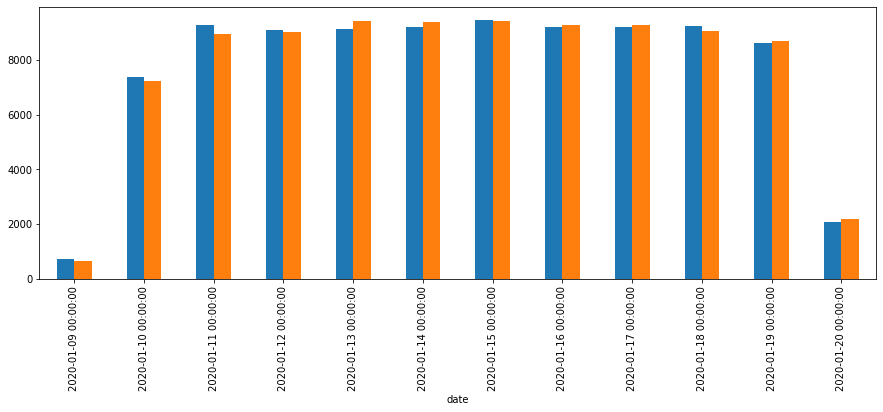

In [49]:
# Проверим, что пользователи набирались в контрольную/тестовую группу одновременно и в одинаковых размерах
tmp = df.pivot_table(index='date', columns='uniq_group_label', aggfunc={'uid':'count'})
print(df['uniq_group_label'].value_counts(normalize=True))
tmp.plot(kind='bar', figsize=(15, 5), legend=False);

In [58]:
# Попытки выяснить какой ивент (или последовательность ивентов) приближает пользователей оплате продукта, привели в Retentioneering.
# И кажется, что это уже перебор. Да и данных для построения нормального графа ивенты -> покупка не хватает (было бы время совершения покупки, вот тогда бы все получилось).
# Единственное, что удалось выяснить с помощью графов – пользователи весьма активно юзают все фичи (feature1,2,3,4) и эта активность не зависит от группы АБ и/или
# наличия/отсутствия статусу покупателя.

# Чтобы показать это на цифрах, посчитаем долю последнего action в пользовательских ивентах и посмотрим в разрезе платящий/не платящий и control/test
# Для вычислений модицицирую написанный выше sql-запрос, так как разбираться в оконках Pandas пока не хочется. 
sql = """
with
    users_labels as (
        select
            experiment,
            uid,
            count(distinct(group_label)) as uniq_group_cnt,
            json_group_array(distinct(group_label)) as uniq_group_label
        from ab_experiments
        where experiment == 'paymentChange'
        group by  experiment, uid
    ),

    users_payments as (
        select
            uid,
            json_group_array(payment_type) as arr_payment_type,
            json_group_array(payment) as arr_payment,
            count(distinct payment) as uniq_payment_cnt
        from ab_payments
        group by uid
    ),

    data as (
        select
            a.uid, a.ts, date(a.ts) as date, a.action,
            l.experiment, l.uniq_group_cnt, json_extract(l.uniq_group_label, '$[0]') as uniq_group_label,
            p.arr_payment_type, p.arr_payment,
            case when p.uniq_payment_cnt is null then 0 else p.uniq_payment_cnt end as uniq_payment_cnt,
            case when p.uniq_payment_cnt is null then 0 else 1 end as is_payment_uid
        from ab_actions as a
        left join users_labels as l on a.uid == l.uid
        left join users_payments as p on a.uid == p.uid
        order by a.uid, a.ts asc
    ),

    latest_action as (
        select
            uniq_group_label, is_payment_uid, latest_action,
            count(distinct uid) as uniq_uid,
            round(count(distinct uid) * 1.0 / sum(count(distinct uid)) over (partition by uniq_group_label, is_payment_uid)  * 100, 2)as percent_uid_by_group_payment
        from (select
                  uniq_group_label, uid,
                  json_extract(json_group_array(action), '$[#-1]') as latest_action,
                  is_payment_uid
              from (select * from data order by uid, ts asc)
              group by uniq_group_label, uid)
        group by uniq_group_label, is_payment_uid, latest_action
    )

select * from latest_action;
"""
tmp = pd.read_sql_query(sql, connect)

# Видим, что драматической разницы в данных нет. Не важно какая группа (control/test) и не важно платил пользователь/не платил. 
# Все фичи юзаются примерно одинаково. На стат.значимость проверять не будут, так как это не является целью данного исследования. 
tmp.pivot_table(index='latest_action', columns=['uniq_group_label', 'is_payment_uid'], aggfunc={'percent_uid_by_group_payment':'min'})

percent_uid_by_group_payment                     
uniq_group_label                      control          test       
is_payment_uid                              0      1      0      1
latest_action                                                     
function1                               19.43  23.84  19.08  22.36
function2                               23.80  19.46  23.72  20.40
function3                               28.28  27.93  28.75  28.40
function4                               28.49  28.77  28.45  28.85

In [71]:
# А теперь посчитаем конверсию, которую будем бустить (судя по всему) в нашем "грядущем" АБ :)
# Так как мы будем менять стоимость продукта с 400 до 160, а покупать могут разное (400/200), то посчитаем конверсию только по тем, кто покупал 400
df['income'] = df['arr_payment'].str.extract('(400|160)')

In [82]:
control_size_all = df[df['uniq_group_label']=='control']['uid'].nunique()
control_size_pay = df[(df['uniq_group_label']=='control')&(df['income']=='400')]['uid'].nunique()
print(f'CR: {control_size_pay/control_size_all:.2%}')

CR: 19.87%


## Дизайн АБ
__Гипотеза__. Если мы уменьши стоимость продукта с 400уе до 160уе, то это позволит увеличить долю платящих пользователей с CR 19.87% на +5.00% (до 24.87%). Потому что продукт станет дешевле с сохранением своего функционала и полезности для пользователей. 

 